In [13]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon
import contextily as cx

In [14]:
# dir_p = '/SNOWDATA/uavsar/imgs'
# res = pd.DataFrame()
# for i, fp in enumerate(glob.glob(os.path.join(dir_p, '*/*.csv'), recursive=True)):
#     df = pd.read_csv(fp)
#     sub = df[['start time of acquisition for pass 1','stop time of acquisition for pass 1','start time of acquisition for pass 2','stop time of acquisition for pass 2','peg heading','approximate upper left latitude',
# 'approximate upper left longitude','approximate upper right latitude','approximate upper right longitude','approximate lower left latitude','approximate lower left longitude','approximate lower right latitude','approximate lower right longitude']]
#     sub['name'] = os.path.basename(fp)
#     res = res.append(sub.iloc[0], ignore_index=True)
# res.to_csv('../../figures/proposal/imgs_map_meta.csv')

In [15]:
def name_map(i):
    j = i.split('_')[0]
    if j == 'peeler':
        return 'Crested Butte, CO'
    elif j == 'rockmt':
        return 'Rocky Mountain, CO'
    elif j == 'silver':
        return 'Silver City, ID'
    elif j == 'lowman':
        return 'Lowman, ID'
    elif j == 'grmesa':
        return 'Grand Mesa, CO'    

def days_between(i):
    return i.replace('.csv','').split('_')[-1].replace('d','')

def peg_head(i):
    j =i.split('_')[1][:3]
    return f'{j}$\degree$'

In [16]:
df = pd.read_csv('../../figures/proposal/imgs_map_meta.csv')
df['start time of acquisition for pass 1'] = pd.to_datetime(df['start time of acquisition for pass 1'])
df['start time of acquisition for pass 2'] = pd.to_datetime(df['start time of acquisition for pass 2'])
df = df.set_index(df['start time of acquisition for pass 1'])
df.sort_index(ascending=True)
table1 = df[['start time of acquisition for pass 2','name']]
table1['Location'] = table1.name.apply(name_map)
table1['Days Between'] = table1.name.apply(days_between).astype('i4')
table1['Flight Heading'] = table1.name.apply(peg_head)
table1 =table1.drop(['name'], axis = 1)
table1 = table1.reset_index()
table1['Acquistion 1 Date'] = table1['start time of acquisition for pass 1'].dt.strftime('%m/%d/%Y')
table1['Acquistion 2 Date'] = pd.to_datetime(table1['start time of acquisition for pass 2'], utc=True).dt.strftime('%m/%d/%Y')
table1= table1.sort_index(ascending=False)
table1[' '] = range(1,len(table1)+1)
table1 = table1[[' ', 'Location', 'Flight Heading', 'Acquistion 1 Date', 'Acquistion 2 Date', 'Days Between']]


/home/zacharykeskinen/anaconda3/envs/gis/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/zacharykeskinen/anaconda3/envs/gis/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/zacharykeskinen/anaconda3/envs/gis/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

In [17]:
gdf = gpd.read_file('../../figures/proposal/imgs_map_meta.csv').drop(['name','peg heading', 'start time of acquisition for pass 1','stop time of acquisition for pass 1','start time of acquisition for pass 2','stop time of acquisition for pass 2'], axis = 1)
for i, r in gdf.iterrows():
    lat_point_list = [r['approximate upper left latitude'],r['approximate upper right latitude'],r['approximate lower right latitude'],r['approximate lower left latitude']]
    lon_point_list = [r['approximate upper left longitude'],r['approximate upper right longitude'],r['approximate lower right longitude'],r['approximate lower left longitude']]
    lat_point_list = [float(i) for i in lat_point_list]
    lon_point_list = [float(i) for i in lon_point_list]
    polygon_geom = Polygon(zip(lon_point_list, lat_point_list))
    crs = {'init': 'epsg:4326'}
    gdf.loc[i, 'geometry'] =  polygon_geom
gdf.crs = crs
gdf.loc[:, 'Location'] = table1.Location

/home/zacharykeskinen/anaconda3/envs/gis/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


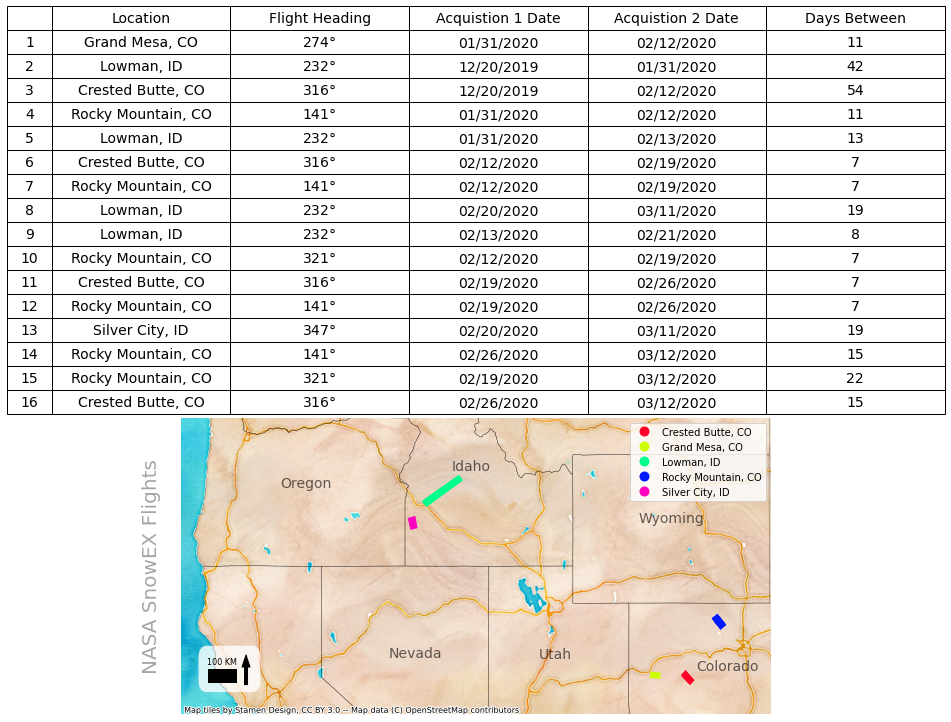

In [18]:
import matplotlib

fig, axes =plt.subplots(2,1, figsize = (16,12))
ax, axmap = axes
data=table1.values

#ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=data,colLabels=table1.columns,loc="center", colWidths = [0.05,0.2,0.2,0.2, 0.2,0.2], cellLoc= 'center')
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1, 2)

x_min, x_max, y_min, y_max = -125, -104, 38, 46

gdf.plot(alpha = 1, ax = axmap, column = 'Location', legend = True, cmap = 'gist_rainbow')
fig = axmap.figure
cb_ax = fig.axes[1] 
cb_ax.tick_params(labelsize=20)

axmap.set_axis_off();
axmap.set_xlim(x_min, x_max)
axmap.set_ylim(y_min, y_max)
cx.add_basemap(axmap, source=cx.providers.Stamen.Watercolor, crs = gdf.crs)
#cx.add_basemap(axmap, source=cx.providers.OpenTopoMap, crs = gdf.crs)
#cx.add_basemap(axmap, source=cx.providers.Stamen.TonerLabels, crs = gdf.crs)

states = gpd.read_file('../../data/aucillary/states/usa-states-census-2014.shp')
states = states.to_crs(gdf.crs)
west = states[states['region'] == 'West']
west.apply(lambda x: axmap.annotate(text=x.NAME, xy= tuple(map(lambda i, j: i + j, x.geometry.centroid.coords[0], (0,.3))), ha='center', va = 'center',fontsize=14, alpha = 0.6),axis=1)
#west.apply(lambda x: axmap.annotate(s=x.NAME, xy= x.geometry.centroid.coords[0], ha='center', va = 'center',fontsize=14, alpha = 0.6),axis=1)
west.boundary.plot(ax=axmap, color='Black', linewidth=.4, alpha = .6)
axmap.text(-0.05, 0.5, 'NASA SnowEX Flights', transform=axmap.transAxes,
        fontsize=20, color='gray', alpha=0.7,
        ha='center', va='center', rotation='90')


#Add north arrow, https://stackoverflow.com/a/58110049/604456
x, y, arrow_length = 0.11, 0.2, 0.1
axmap.annotate('', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=3, headwidth=8),
            ha='center', va='center', fontsize=8,
            xycoords=axmap.transAxes)

#Add scale-bar
x, y, scale_len = x_min+1, y_min+.9, 0.9 #arrowstyle='-'
scale_rect = matplotlib.patches.Rectangle((x,y),scale_len,.3,linewidth=3,edgecolor='k',facecolor='k', zorder = 2)
axmap.add_patch(scale_rect)
plt.text(x+scale_len/2, y+0.46, s='100 KM', fontsize=8, horizontalalignment='center')

leg_rect = matplotlib.patches.FancyBboxPatch((x-0.08,y),1.6,0.65,linewidth=0,edgecolor='k',facecolor='white', zorder = 1, alpha = 0.8)
axmap.add_patch(leg_rect)

plt.savefig('../../figures/proposal/flights.png', dpi = 300)